In [1]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

import math
import torch
import numpy as np
from collections import namedtuple
import torch.optim as optim
from itertools import count
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import gym
import minigrid
from gym_minigrid.wrappers import FullyObsWrapper, ImgObsWrapper
from customwrappers import FreeMovementEnvWrapper, OneHotObsWrapper

from agent import EpsilonGreedyStrategy, Agent, Abstract_agent
from replay_memory import ReplayMemory,extract_tensors
from models import QValues,DQN_CNN,QTable
from plot import plot

/Users/alessio/.virtualenvs/minigrid/lib/python3.10/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
batch_size = 50
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 50 

memory_size = 100000
lr = 0.01
num_episodes = 1000

In [3]:
Experience = namedtuple(
    "Experience", 
    ("state", "action", "next_state", "reward")
)

device = torch.device("cuda" if torch .cuda.is_available() else "cpu")

In [4]:
env_base = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode="rgb_array",highlight = False)
env_obs = FullyObsWrapper(env_base)
env_onehot = OneHotObsWrapper(env_obs,max_objects=16)

environment set up


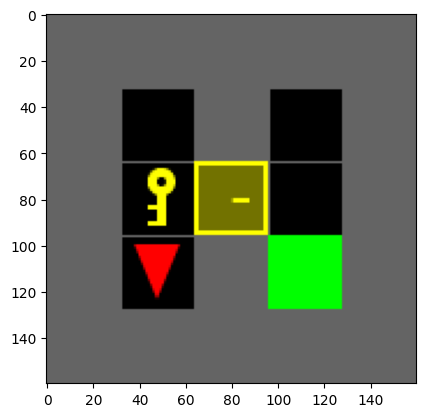

In [5]:
env_onehot.reset()
img = env_onehot.render()
plt.imshow(img)
print("environment set up")

In [6]:
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, env_onehot.num_actions_available(), device)
abstract_agent = Abstract_agent(strategy, device)
memory = ReplayMemory(memory_size)


In [7]:
policy_net = DQN_CNN(env_onehot.height,env_onehot.width,env_onehot.depth,env_onehot.num_actions_available()).to(device)
target_net = DQN_CNN(env_onehot.height,env_onehot.width,env_onehot.depth,env_onehot.num_actions_available()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN_CNN(
  (conv1): Conv2d(16, 12, kernel_size=(2, 2), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 24, kernel_size=(2, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=216, out_features=100, bias=True)
)

In [8]:
optimizer_dict = {}


In [9]:
import numpy as np
q_table = QTable()


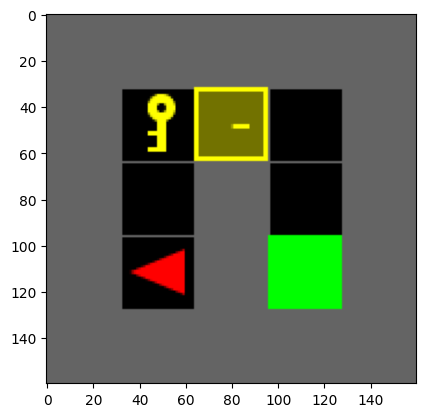

Series([], Name: (1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), dtype: float64)
-1    0.0
Name: (0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), dtype: float64


KeyboardInterrupt: 

In [10]:
import random
from IPython.display import clear_output


alpha_abstract = 0.1
gamma_abstract = 0.6
epsilon_abstract = 0.1

plt.ion()
fig, f = plt.subplots()

episode_reward=[]
losses_tot={}
for episode in range(0,num_episodes):
    obs = env_onehot.reset()
    image = obs["image"].copy()
    abstract_state = obs["state"].copy()
    
    img = env_onehot.render()
    f.imshow(img)
    plt.pause(.1)

    
    tot_reward = 0
    for abstract_step in count():
        abstract_action = abstract_agent.select_action(abstract_state,q_table)
        
        optimizer = optimizer_dict.setdefault(abstract_action,optim.RMSprop(params=policy_net.parameters(), lr=0.001))
        for ministep in count():
            action = agent.select_action(torch.tensor(image).permute(2,0,1).float().unsqueeze(0), policy_net, abstract_action)
            state = image.copy()
            old_abstract_state = abstract_state.copy()
            image, abstract_state, reward, terminated, truncated = env_onehot.step(action,abstract_action)
            abstract_agent.num_actions = len(env_onehot.abstract_actions)
            tot_reward += reward
            
            img = env_onehot.render()
            f.imshow(img)
            plt.show() 
            plt.pause(.5)
 


            memory.push(Experience(torch.tensor(image).permute(2,0,1).float().unsqueeze(0), action, torch.tensor(image).permute(2,0,1).float().unsqueeze(0), reward),abstract_action)
            losses = []
            if memory.can_provide_sample(batch_size,abstract_action):
                experiences = memory.sample(batch_size,abstract_action)
                states, actions, rewards, next_states = extract_tensors(Experience,experiences)
                current_q_values = QValues.get_current(policy_net, states, actions,abstract_action)
                next_q_values = QValues.get_next(target_net, next_states,abstract_action)
                target_q_values = (next_q_values * gamma) + rewards
                criterion = nn.SmoothL1Loss()
                
                loss = criterion(current_q_values, target_q_values.unsqueeze(1))
                losses.append(torch.mean(loss).item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
            if terminated or ministep%100==0:
                if not abstract_action:
                    abstract_action=-1
                losses_tot.setdefault(abstract_action,[])
                losses_tot[abstract_action].append(np.mean(losses))
                break
            
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        abstract_reward = 0
        if abstract_state==np.zeros(env_onehot.max_objects):
            abstract_reward = 1
        
        old_value = q_table.take(old_abstract_state, abstract_action)
        q_table.take(abstract_state, abstract_action)
        next_max = q_table.val_max(abstract_state)
        
        new_value = (1 - alpha_abstract) * old_value + alpha_abstract * (abstract_reward + gamma_abstract * next_max)
        q_table.q_table.loc[tuple(old_abstract_state), abstract_action] = new_value

    episode_reward.append(tot_reward)
    if episode % 100 == 0:
        print(f"Episode: {episode}")
        for i in q_table.q_table.columns:
            plot(losses_tot[i],10)
            
        


In [12]:
2%100

2

In [ ]:
extract_tensors(Experience,experiences)

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [ ]:
experiences = memory.sample(batch_size,abstract_action)
states, actions, rewards, next_states = extract_tensors(Experience,experiences)

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [ ]:
from scipy.special import softmax
import pandas as pd
df = pd.DataFrame([[0,2],[2,2]])
df.apply(softmax,axis=1)

0    [0.11920292202211755, 0.8807970779778823]
1                                   [0.5, 0.5]
dtype: object

In [ ]:
df[3]

KeyError: 3

In [ ]:
x=np.array([1,2])
tuple(x)

(1, 2)